In [1]:
import torch
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
batch_size = 20

trans = transforms.Compose([transforms.Resize((224,224)),
                            transforms.RandomHorizontalFlip(p=0.5),
                            transforms.RandomRotation(10),
                           transforms.ToTensor(),])

tra_test = transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor()])

train_data = datasets.ImageFolder('train', transform= trans)
valid_data = datasets.ImageFolder('valid', transform= trans)
test_data = datasets.ImageFolder('test', transform= tra_test)

train_loader = DataLoader(train_data, shuffle= True, batch_size= batch_size)
valid_loader = DataLoader(valid_data, shuffle= True, batch_size= batch_size)
test_loader = DataLoader(test_data, shuffle = True, batch_size= batch_size)



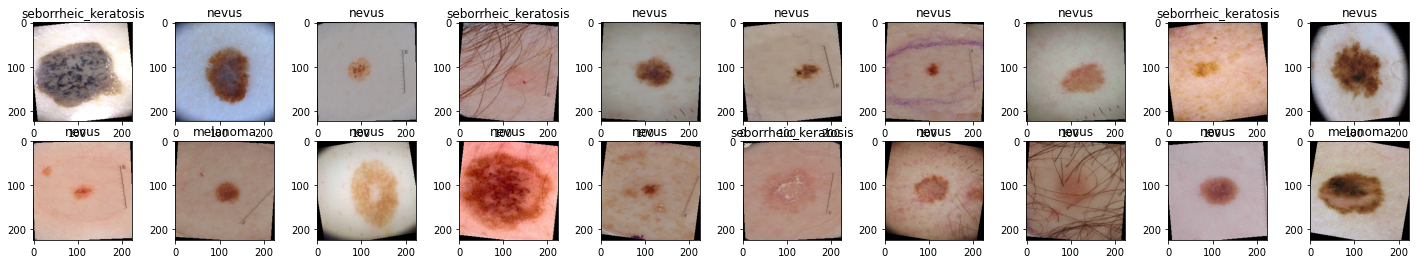

In [3]:
dataiter = iter(train_loader)
img, label = dataiter.next()
img = img.numpy()

fig = plt.figure(figsize=(25,4))
for i in range(batch_size):
    ax = fig.add_subplot(2,10, i+1)
    ax.imshow(np.transpose(img[i],(2,1,0)))
    ax.set_title( train_data.classes[label[i]])

In [4]:
from torch import nn
vgg = models.vgg19(pretrained=True)
vgg.classifier[6].out_features = len(train_data.classes)

# vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, len(train_data.classes))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg.to(device)
print(vgg)
for param in vgg.features.parameters():
    param.requires_grad = False

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
from torch import nn, optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.classifier.parameters(), lr= 0.001)


In [6]:
def train_vgg(epochs):    
    try:
        vgg.load_state_dict(torch.load('cancer.pt'))
        print('Resume training')
        
    except:
        print('Train form scratch')
        
    finally:
        
        min_valid_loss= np.infty
        for e in range(epochs):
            train_loss, valid_loss = 0,0

            vgg.train()
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)

                y_hat = vgg.forward(x)
                optimizer.zero_grad()

                loss = criterion(y_hat, y)

                loss.backward()
                optimizer.step()

                train_loss += loss.item() * x.size(0)

            vgg.eval()    
            for x, y in valid_loader:
                x, y = x.to(device), y.to(device)
                y_hat = vgg.forward(x)
                loss= criterion(y_hat, y) 
                valid_loss += loss.item()*x.size(0)

            train_loss = train_loss / len(train_data)
            valid_loss = valid_loss/ len(valid_data)

            print(f'epochs: {e+1}, train_loss: {train_loss}, valid_loss: {valid_loss}')

            if valid_loss < min_valid_loss and e > 0:
                torch.save(vgg.state_dict(), 'cancer.pt')
                min_valid_loss = valid_loss
                print('Model Saved')

In [7]:
train_vgg(5)

Resume training
epochs: 1, train_loss: 0.6988010430335998, valid_loss: 0.7731714089711507
epochs: 2, train_loss: 0.684239926636219, valid_loss: 0.8348529974619547
Model Saved
epochs: 3, train_loss: 0.6847822117805481, valid_loss: 0.7930079936981201
Model Saved
epochs: 4, train_loss: 0.6761989268660545, valid_loss: 0.7809251745541891
Model Saved
epochs: 5, train_loss: 0.6811773952841759, valid_loss: 0.8008540272712708


In [8]:
test_loss, correct, total=0,0,0


vgg.eval()
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    y_hat = vgg.forward(x)
    loss = criterion(y_hat, y)
    
    test_loss += loss.item() *x.size(0)
    #my solution
    pred, indacies = y_hat.topk(1)
    # indacies here are representing the classes index wich are 1000, maybe because we didn't
    # change the last linear layer correctly
    total += x.size(0)
    correct += torch.sum(torch.eq(y.view_as(indacies), indacies))
    
            
print('Test Loss: {:.6f}\n'.format(test_loss/len(test_data)))

print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
 

Test Loss: 0.862319


Test Accuracy: 63% (379/600)


In [9]:
from PIL import Image
def predict_lesion(img_path):
    img = Image.open(img_path).convert('RGB')
    img = tra_test(img).unsqueeze(0)
    vgg.load_state_dict(torch.load('cancer.pt'))
    y_hat = vgg.forward(img.to(device))
    value, index = y_hat.topk(1)
    print(train_data.classes[index])
    plt.imshow(np.transpose(img.squeeze(0), (2,1,0)))

nevus


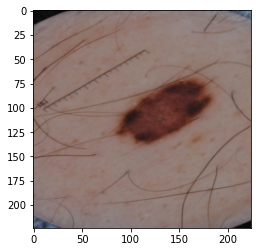

In [10]:
predict_lesion(r'C:\Users\Abody\Desktop\cancer detection\test\nevus\ISIC_0012092.jpg')

nevus


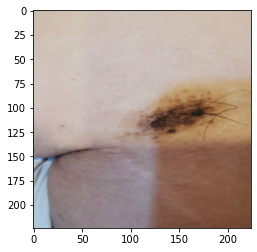

In [11]:
predict_lesion(r'C:\Users\Abody\Desktop\cancer detection\test.jpg')

nevus


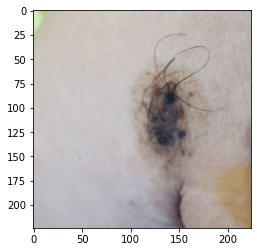

In [12]:
predict_lesion(r'C:\Users\Abody\Desktop\cancer detection\test1.jpg')

nevus


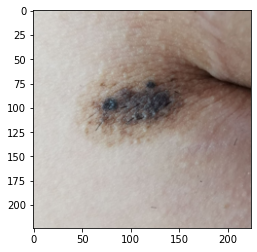

In [13]:
predict_lesion(r'C:\Users\Abody\Desktop\cancer detection\test2.jpg')

nevus


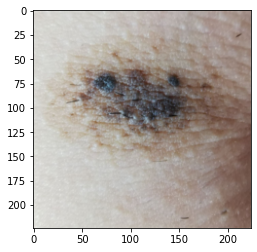

In [14]:
predict_lesion(r'C:\Users\Abody\Desktop\cancer detection\test3.jpg')